# Skimlit Abstract Labeling NLP Project

By: `Pozang`.

This notebook is a practice of **NLP** SkimLit (skim literature) classification of an abstract in research. For more specificially, I will be replicating the deep learning model behind the 2017 paper [*Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251)

The paper presented a new dataset called [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.*](https://arxiv.org/pdf/1710.06071) which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

What this notebook going to cover:
1. Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
2. Import the dataset to the notebook
3. Write a preprocessing function to prepare the data for modelling
  * Seperate them from the sentence, label, `line number` and `total lines` (feature engineering data) into **DataFrame**.
    * Takes `sentences` as **x** for dataset and `target` as the label to predict.
  * Implementing feature engineering to the sentence to be as the characters `a`, `b`, `c`... etc.
  * As well as `line number` and `total lines` in each label.
4. Create Dataset for the model with [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API
5. Build the multi-models using [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) pre-trained!
  * Token and Character embeddings model
  * Positional, Token, and Character embedding model
6. Save and Load a model
7. Visualize model predictions
8. Find the most wrong predictions
9. Making predictions on PubMed abstracts from the wild


In [ ]:
# check GPU avalability
!nvidia-smi

Sat Jul 20 07:53:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Libraries required

In [ ]:
import tensorflow as tf
!pip3 install -q tensorflow-text==2.15.0
import tensorflow_text as tf_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.2 MB/s eta 0:00:00


## Get Dataset

In [ ]:
!unzip -q text_label_classifier_dataset.zip

Or directly clone the repo from github: `!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git`

In [ ]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


The dataset consists of `200k` abstracts with real numbers and replaced by sign as well as the `20k` abstracts.

For this practice, I use the `20k` dataset with replaced numbers for time efficiency...

## Visualize Dataset

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# create function to read a file
def read_file(file_name):
  with open(file_name, 'r') as f:
    return f.readlines()

In [ ]:
train_file = read_file(filenames[2])
valid_file = read_file(filenames[1])
test_file = read_file(filenames[0])

train_file[:20], len(train_file)

(['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) -

The overview of dataset look like this. Each abstract has unique id started with `###` and each sentence has label behind it, (`OBJECTIVE, BACKGROUND, METHOD, RESULTS, CONCLUSIONS`).

All we need it's only the labels and the sentences itself, also as I mention earlier that we need `line_number` for each sentence in an abstract and `total_lines` per abstract as part of feature engineering data to help the model get maximum performance.

## Preprocessing Dataset

Let's create a function to make a data structure like this,

Example returned preprocessed sample (a single line from an abstract):
```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

```

In [ ]:
def preprocess_text(text_file):

  empty_string = ''
  abstract_samples = []

  for line in text_file:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text(train_file)
valid_samples = preprocess_text(valid_file)
test_samples = preprocess_text(test_file)

train_samples[:12], len(train_samples)

([{'target': 'OBJECTIVE',
   'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
   'line_number': 0,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 1,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 2,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'line_number': 3,
   'total_lines': 11},
  {'target': 'METHODS',
   'text': 'secondary outcome measures included 

In [ ]:
len(train_samples), len(valid_samples), len(test_samples)

(180040, 30212, 30135)

Perfect!!!

Let's make it better to visualize with `DataFrame`

### Text Sentence preprocessing

In [ ]:
train_df = pd.DataFrame(train_samples)
valid_df = pd.DataFrame(valid_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# check distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

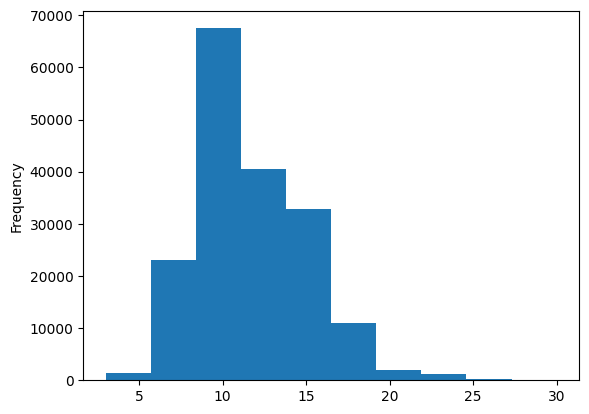

In [ ]:
train_df.total_lines.plot.hist();

Create feature dataset from a sentences

In [ ]:

# take only text from dataframe into list
train_sentences = train_df["text"].to_list()
valid_sentences = valid_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(valid_sentences), len(test_sentences)

(180040, 30212, 30135)

Create dataset labels from **target** DataFrame encode with `one_hot` from [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#onehotencoder)

In [ ]:
# create one hot labels to fit into a model
one_hot = OneHotEncoder(sparse_output=False)

train_labels_encode = one_hot.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
valid_labels_encode = one_hot.fit_transform(valid_df.target.to_numpy().reshape(-1, 1))
test_labels_encode = one_hot.fit_transform(test_df.target.to_numpy().reshape(-1, 1))
train_labels_encode[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
len(train_labels_encode), len(valid_labels_encode), len(test_labels_encode)

(180040, 30212, 30135)

Decode the label from `one_hot` encoding

In [ ]:
# Make the labels
labels = LabelEncoder()

train_labels = labels.fit_transform(train_df.target.to_numpy())
valid_labels = labels.fit_transform(valid_df.target.to_numpy())
test_labels = labels.fit_transform(test_df.target.to_numpy())
train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [ ]:
len(train_labels), len(valid_labels), len(test_labels)

(180040, 30212, 30135)

In [ ]:
# take the class name from label decoder
class_names = labels.classes_
num_classes = len(class_names)
class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

### Character Sentence preprocessing

Not only pass in token/words in dataset, we add of each characters in the model as well to be train.

In [ ]:
# create a function to split all characters in sentence
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in valid_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
len(train_chars), len(valid_chars), len(test_chars)

(180040, 30212, 30135)

## Create Text Vectorizer

Part of tokenization for each token in one sentence

In [ ]:
# How long is each sentence on average?
len_sens = [len(sentence.split()) for sentence in train_sentences]
average_words = int(np.mean(len_sens))
average_words

26

In [ ]:
# find the max sentence
max(len_sens)

296

In [ ]:
# How long of a sentence covers 93% of the lengths?
output_seq_len = int(np.percentile(len_sens, 93))
output_seq_len

50

In [ ]:
# from default of the paper
max_vocabs = 68000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocabs,  #total posible vocabs in dataset, check the paper
                                                    standardize='lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    ngrams=None,
                                                    output_mode='int',
                                                    output_sequence_length=output_seq_len)  #maximum token in 1 sentence

In [ ]:
# get adapt with the dataset
text_vectorizer.adapt(train_sentences)

In [ ]:
 # check the text_vectorizer learned
 print(f"Max vocabs: {len(text_vectorizer.get_vocabulary())}")
 print(f"Top 5: {text_vectorizer.get_vocabulary()[:5]}")
 print(f"Bottom 5: {text_vectorizer.get_vocabulary()[-5:]}")

Max vocabs: 64841
Top 5: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# check config
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 50,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Text Embedding

Converts tokens generated from the tokenization process into a fixed-dimensional **vector** representation that maps semantic relationships between tokens.

In [ ]:
# Create token embedding layer
token_embed = keras.layers.Embedding(input_dim=max_vocabs, # length of vocabulary
                               output_dim=128,  # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True,  # Use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

## Create Character Vectorizer

Same as tokenization, but this time for each character

In [ ]:
# What's the average character length?
char_lens = [len(chars) for chars in train_chars]
mean_char_len = int(np.mean(char_lens))
mean_char_len

297

In [ ]:
# find the max sentence
max(char_lens)

2771

In [ ]:
# Find what character length covers 93% of sequences
output_char_len = int(np.percentile(char_lens, 93))
output_char_len

537

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #alphabet + space + OOV token

char_vectorizer = keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# get adapt with the dataset
char_vectorizer.adapt(train_chars)

In [ ]:
 # check the text_vectorizer learned
 print(f"Max characters: {len(char_vectorizer.get_vocabulary())}")
 print(f"Top 5: {char_vectorizer.get_vocabulary()[:5]}")
 print(f"Bottom 5: {char_vectorizer.get_vocabulary()[-5:]}")

Max characters: 28
Top 5: ['', '[UNK]', 'e', 't', 'i']
Bottom 5: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p a t i e n t   e x p e r i e n c e   w a s   m e a s u r e d   u s i n g   a   n e w   l u n g   c a n c e r   p a t i e n t   q u e s t i o n n a i r e   i n   t h e   i n t e r v e n t i o n   g r o u p   .

Length of chars: 90

Vectorized chars:
[[14  5  3  4  2  6  3  2 24 14  2  8  4  2  6 11  2 20  5  9 15  2  5  9
  16  8  2 10 16  9  4  6 18  5  6  2 20 12 16  6 18 11  5  6 11  2  8 14
   5  3  4  2  6  3 26 16  2  9  3  4  7  6  6  5  4  8  2  4  6  3 13  2
   4  6  3  2  8 21  2  6  3  4  7  6 18  8  7 16 14  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Create Character Embedding

In [ ]:
# Create char embedding layer
char_embed = keras.layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p a t i e n t   e x p e r i e n c e   w a s   m e a s u r e d   u s i n g   a   n e w   l u n g   c a n c e r   p a t i e n t   q u e s t i o n n a i r e   i n   t h e   i n t e r v e n t i o n   g r o u p   .

Embedded chars (after vectorization and embedding):
[[[ 1.93221606e-02 -6.31908327e-03  4.63025831e-02 ... -4.81111407e-02
   -2.17031837e-02 -3.81105058e-02]
  [-4.32848223e-02  4.00086679e-02 -1.41265765e-02 ... -1.94261800e-02
    8.60207155e-03  4.37932089e-03]
  [ 7.98478723e-05 -2.07067486e-02  2.38007419e-02 ...  2.54246630e-02
   -9.87454504e-03 -1.53926723e-02]
  ...
  [-7.22295046e-03 -1.74746737e-02 -2.93340571e-02 ...  2.99145691e-02
   -1.93095449e-02 -1.88577771e-02]
  [-7.22295046e-03 -1.74746737e-02 -2.93340571e-02 ...  2.99145691e-02
   -1.93095449e-02 -1.88577771e-02]
  [-7.22295046e-03 -1.74746737e-02 -2.93340571e-02 ...  2.99145691e-02
   -1.93095449e-02 -1.88577771e-02]]]

Character embedding shape: (1, 53

## Create Dataset API

With: [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
from tensorflow.data import Dataset

train_char_token_dataset = Dataset.zip((Dataset.from_tensor_slices((train_sentences, train_chars)),
                                       Dataset.from_tensor_slices(train_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_token_dataset = Dataset.zip((Dataset.from_tensor_slices((valid_sentences, valid_chars)),
                                       Dataset.from_tensor_slices(valid_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = Dataset.zip((Dataset.from_tensor_slices((test_sentences, test_chars)),
                                       Dataset.from_tensor_slices(test_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In one object dataset, are tuples consists of `tokens` and `characters` dataset with the encode labels

## Create Models

The model we build is multi-models that takes several models into one big architecture...

### Create Callbacks

Early stopping to prevent keep learning if it's not improving

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### Pre-trained model for Token with Chars Model

The first multi-model is `token + chars model` with pre tranined model from [BERT PubMed Expert](https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3)

In [ ]:
random_sentence = random.choice(train_sentences)
random_sentence

'there were no significant differences in geometric mean titers ( gmt ) or the proportions of subjects with @-fold rise in antibody responses and titers @ for any vaccine group or between age strata for @-h@n@ after the first or second dose , although the vaccine sequence affected the titers to the iiv@ antigens .'

In [ ]:
# Load the BERT encoder and preprocessing models
preprocess = hub.load('https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3')
bert = hub.load('https://www.kaggle.com/models/google/experts-bert/TensorFlow2/pubmed/2')

# Convert to BERT preprocess
bert_input = preprocess([random_sentence])

# Feed the inputs to the model to get the pooled and sequence outputs
bert_output = bert(bert_input, training=False)
pooled_output = bert_output['pooled_output']
sequence_output = bert_output['sequence_output']

print(random_sentence, '\n')
print(f"Preprocessing Text:\n{bert_input}", '\n')
print(f"BERT passed in:\n{bert_output}", '\n')
print(f"Pooled output:\n{pooled_output}\n")
print(f"Sequence output:\n{sequence_output}\n")

there were no significant differences in geometric mean titers ( gmt ) or the proportions of subjects with @-fold rise in antibody responses and titers @ for any vaccine group or between age strata for @-h@n@ after the first or second dose , although the vaccine sequence affected the titers to the iiv@ antigens . 

Preprocessing Text:
{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  2045,  2020,  2053,  3278,  5966,  1999, 14965,  2812,
    

In preprocessing dataset, instead using token and embedding object that we build before... **BERT** model takes its own preprocess that turns out some results. For more information about how it works, [click here](https://www.kaggle.com/models/google/experts-bert/tensorFlow2/pubmed/2?tfhub-redirect=true)

In [ ]:
preprocess = hub.KerasLayer('https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3')
bert = hub.KerasLayer('https://www.kaggle.com/models/google/experts-bert/TensorFlow2/pubmed/2', trainable=False)

#1. Token model
token_inputs = keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
preprocess_layer = preprocess(token_inputs)
bert_model = bert(preprocess_layer)
pooled_output = bert_model['pooled_output'] # [batch_size, 768]
sequence_output = bert_model['sequence_output'] # [batch_size, seq_length, 768]
x = keras.layers.Dense(256, activation='tanh')(pooled_output)
token_outputs = keras.layers.Dense(128, activation='tanh')(x)
token_model = keras.Model(token_inputs, token_outputs)

#2. Char model
char_inputs = keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi = keras.layers.Bidirectional(keras.layers.LSTM(25, activation='tanh'))(char_embeddings)
char_model = keras.Model(char_inputs, char_bi)

#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = keras.layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

#4. create output layer
combine_dropout = keras.layers.Dropout(0,5)(token_char_concat)
combine_dense = keras.layers.Dense(128, activation='tanh')(combine_dropout)
final_dropout = keras.layers.Dropout(0.5)(combine_dense)
output_layer = keras.layers.Dense(num_classes, activation='softmax')(final_dropout)

#5. combine all model
token_char_model = keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="Token_and_char_model")

# compile model
token_char_model.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

# check model summary
token_char_model.summary()

Model: "Token_and_char_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['token_inputs[0][0]']        
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                               

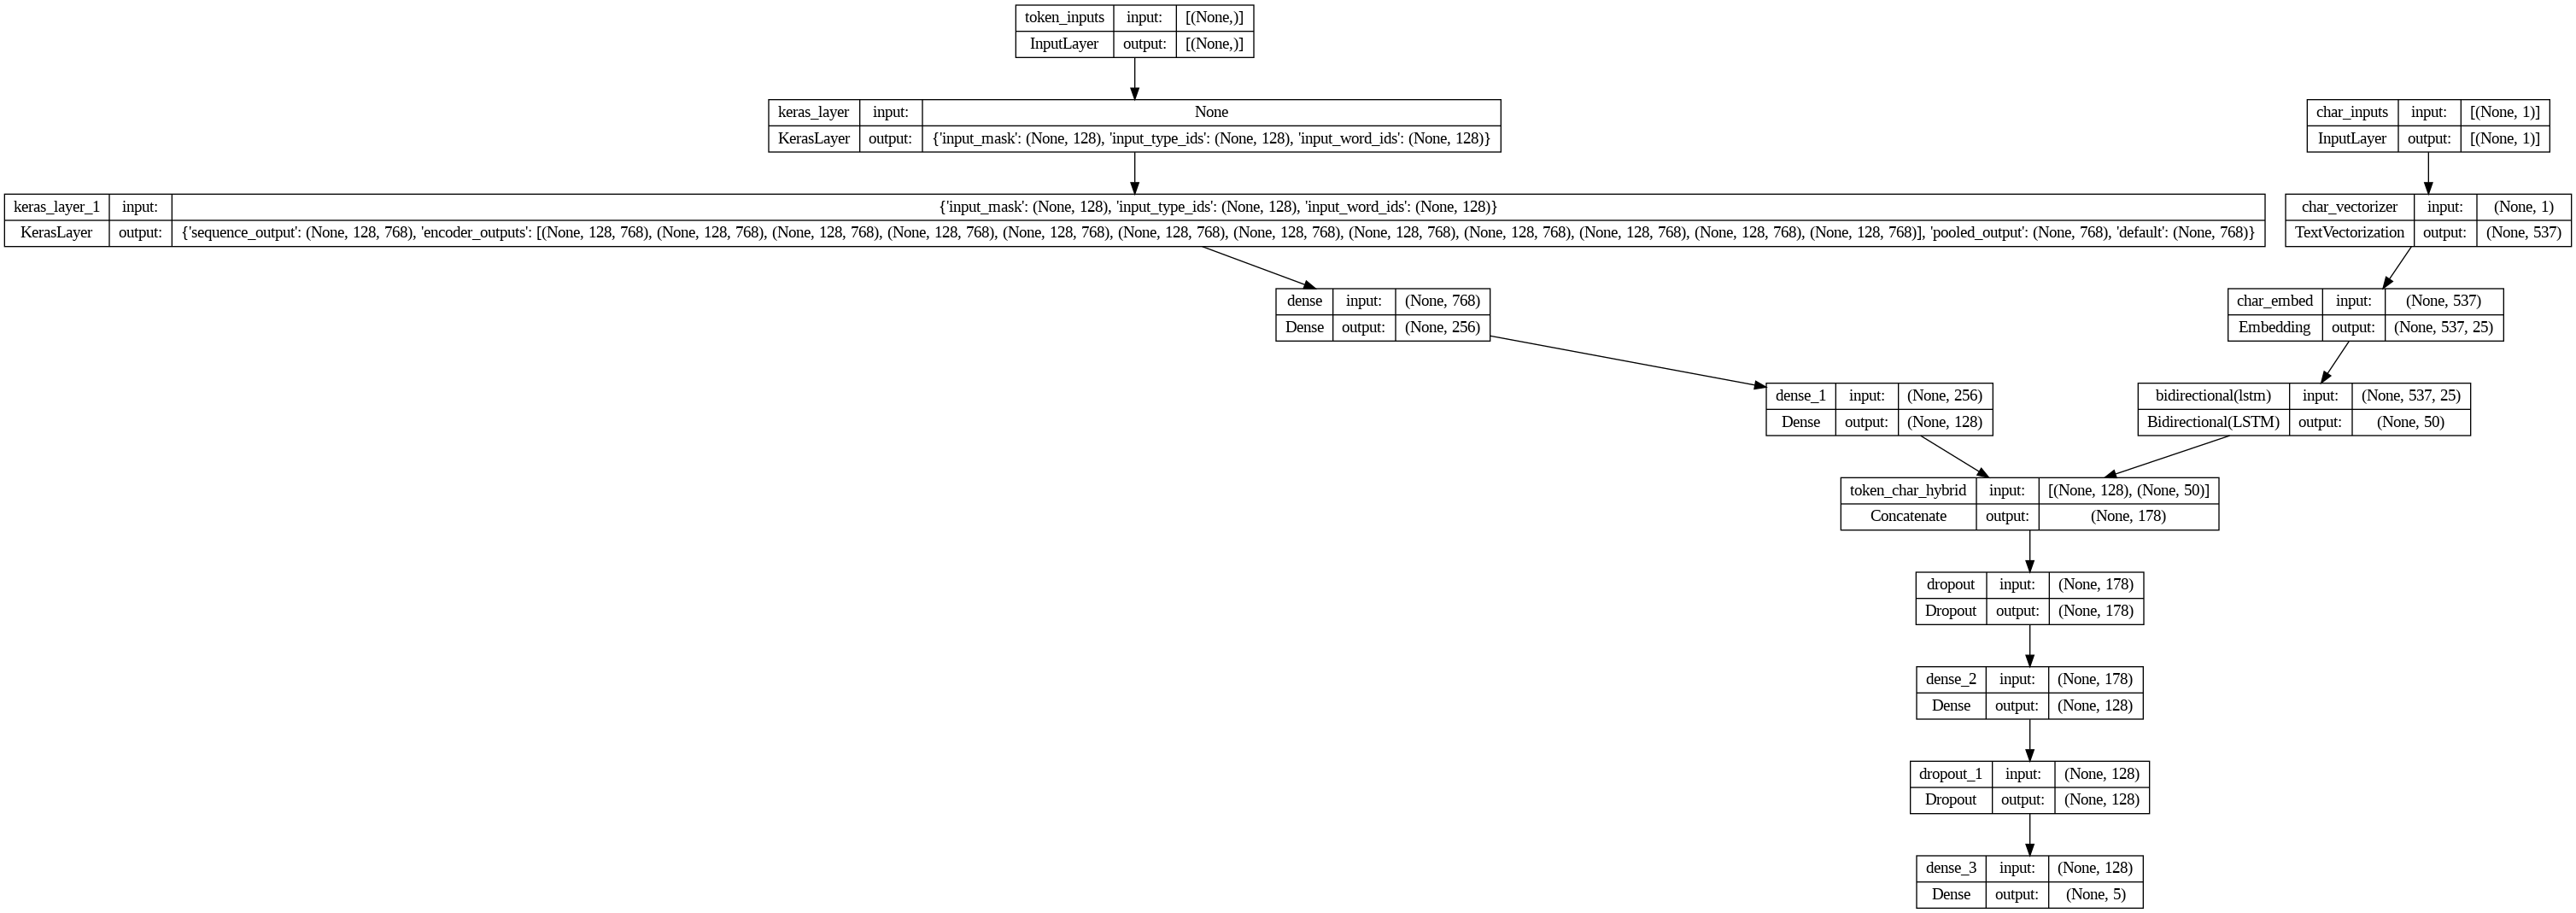

In [ ]:
# Plot hybrid token and character model
keras.utils.plot_model(token_char_model, show_shapes=True)

In [ ]:
# Check model layer
for i, layer in enumerate(token_char_model.layers):
  print(i, layer.name, layer.trainable)

0 token_inputs True
1 keras_layer False
2 char_inputs True
3 keras_layer_1 False
4 char_vectorizer True
5 dense True
6 char_embed True
7 dense_1 True
8 bidirectional True
9 token_char_hybrid True
10 dropout True
11 dense_2 True
12 dropout_1 True
13 dense_3 True


In [ ]:
# Fit a model
EPOCHS = 10

history_one = token_char_model.fit(train_char_token_dataset,
                                   epochs=EPOCHS,
                                   steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                                   validation_data=valid_char_token_dataset,
                                   validation_steps=int(0.1 * len(valid_char_token_dataset)),
                                   callbacks=[early_stopping])

Epoch 1/10
562/562 [==============================] - 275s 464ms/step - loss: 1.0581 - accuracy: 0.7755 - val_loss: 0.9343 - val_accuracy: 0.8371
Epoch 2/10
562/562 [==============================] - 256s 456ms/step - loss: 0.9463 - accuracy: 0.8346 - val_loss: 0.9049 - val_accuracy: 0.8378
Epoch 3/10
562/562 [==============================] - 255s 454ms/step - loss: 0.9261 - accuracy: 0.8386 - val_loss: 0.8878 - val_accuracy: 0.8537
Epoch 4/10
562/562 [==============================] - 255s 455ms/step - loss: 0.9183 - accuracy: 0.8435 - val_loss: 0.8834 - val_accuracy: 0.8594
Epoch 5/10
562/562 [==============================] - 247s 440ms/step - loss: 0.9143 - accuracy: 0.8475 - val_loss: 0.8980 - val_accuracy: 0.8451
Epoch 6/10
562/562 [==============================] - 248s 441ms/step - loss: 0.9167 - accuracy: 0.8429 - val_loss: 0.8891 - val_accuracy: 0.8561
Epoch 7/10
562/562 [==============================] - 254s 452ms/step - loss: 0.9059 - accuracy: 0.8530 - val_loss: 0.8853 -

#### Evalaute Token + Char models performance

In [ ]:
token_char_results = token_char_model.evaluate(valid_char_token_dataset)
token_char_results

945/945 [==============================] - 339s 358ms/step - loss: 0.8851 - accuracy: 0.8588


[0.8850782513618469, 0.8587978482246399]

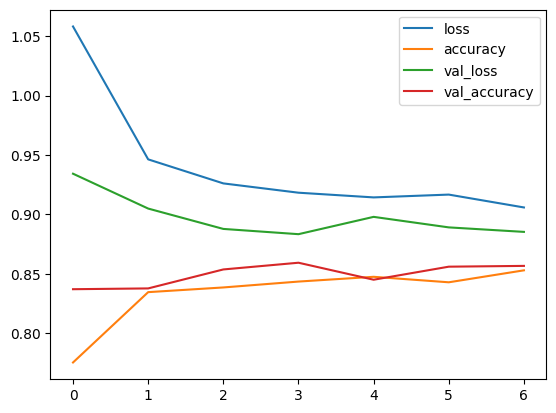

In [ ]:
#Plot model history learned
pd.DataFrame(history_one.history).plot();

The model history learn it's not quite well that indicated overfitting, let's check in the model predictions

In [ ]:
# Make prediction to the test dataset
token_char_probs = token_char_model.predict(test_char_token_dataset)
token_char_preds = tf.argmax(token_char_probs, axis=1)
token_char_preds

942/942 [==============================] - 335s 355ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
test_labels.shape

(30135,)

In [ ]:
# Evaluate with confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_display(y_true, y_preds, figsize=(12, 10)):
  """
  Plot confusion matrix of classification label.
  """
  cm = confusion_matrix(y_true, y_preds)
  cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
  fig, ax = plt.subplots(figsize=figsize)
  cmp.plot(ax=ax, cmap='magma');

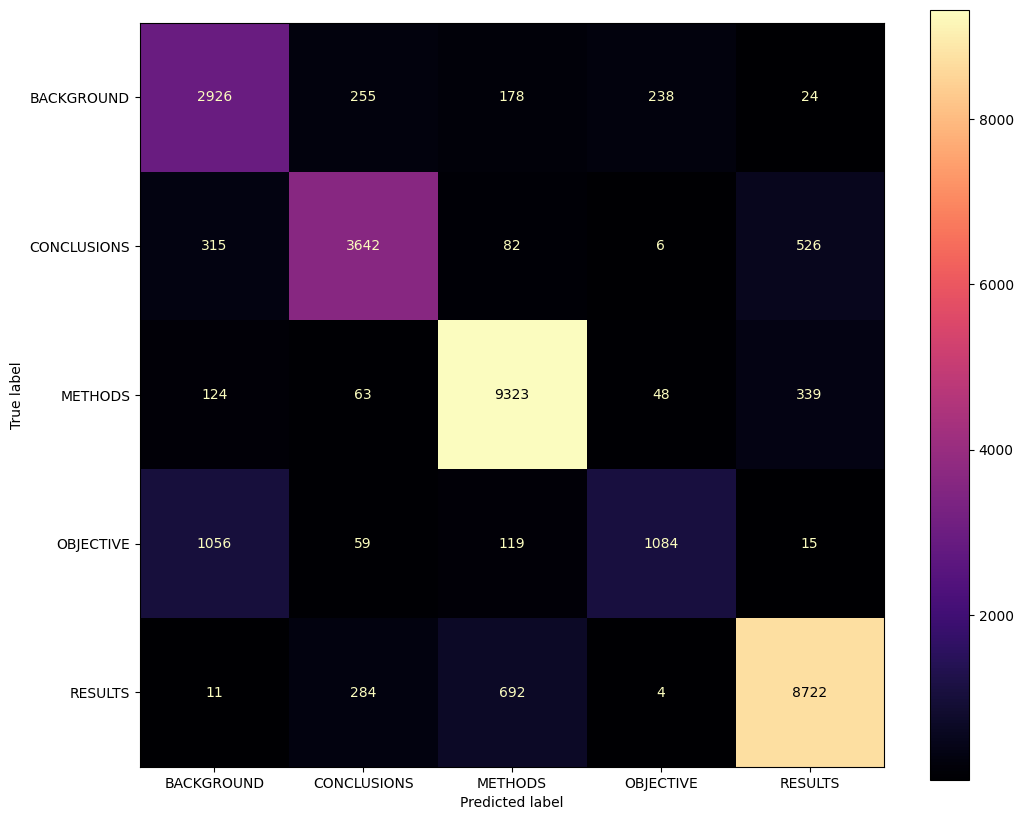

In [ ]:
cm_display(test_labels, token_char_preds)

The confusion matrix shows how model predict the label from each other. And because the labels itself it's not by the same amount, it looks like a little bit of mess. However the model does pretty good in predict most of the labels, except `OBJECTIVE` label. The model still confuse between sentence of a `BACKGROUND` or `OBJECTIVE`.

Now it's time to move in the second model...

### Positional + Token + Char Model

This time is multi-model with additional `positional + token + chars model` embeddings from `line_number` and `total_lines` come in play!

#### Create Positional Embedding

With:
* `line_number`
* and `total_lines`

In [ ]:
# value count line_number
train_df.line_number.value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

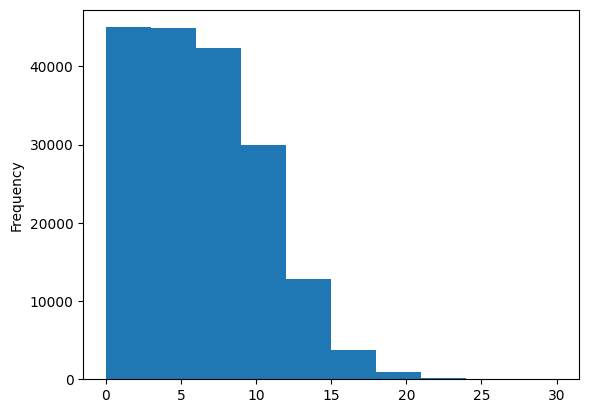

In [ ]:
# check distribution
train_df.line_number.plot.hist();

In [ ]:
# Check the the "line_number" of cover 95%
line_number_depth = np.percentile(train_df.line_number, 98)
line_number_depth

15.0

In [ ]:
# Encode "line_number" to one hot with depth of 95% coverage of values
train_line_number_encode = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
valid_line_number_encode = tf.one_hot(valid_df.line_number.to_numpy(), depth=15)
test_line_number_encode = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

train_line_number_encode[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Let's do the same thing with `total_lines` column

In [ ]:
train_df.total_lines.value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

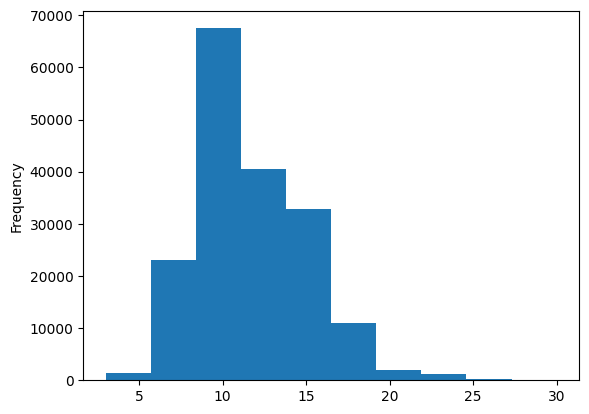

In [ ]:
# check histogram
train_df.total_lines.plot.hist();

In [ ]:
# Check the "total_lines" of cover 95%
total_lines_depth = np.percentile(train_df.total_lines, 95)
int(total_lines_depth)

18

In [ ]:
# Encode "total_lines" to one hot with depth of 95% coverage of values
train_total_lines_encode = tf.one_hot(train_df.total_lines.to_numpy(), depth=18)
valid_total_lines_encode = tf.one_hot(valid_df.total_lines.to_numpy(), depth=18)
test_total_lines_encode = tf.one_hot(test_df.total_lines.to_numpy(), depth=18)

train_total_lines_encode[:15]

<tf.Tensor: shape=(15, 18), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 

In [ ]:
train_line_number_encode.shape, valid_line_number_encode.shape, test_line_number_encode.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]), TensorShape([30135, 15]))

In [ ]:
train_total_lines_encode.shape, valid_total_lines_encode.shape, test_total_lines_encode.shape

(TensorShape([180040, 18]), TensorShape([30212, 18]), TensorShape([30135, 18]))

Now let's create new dataset with add `line_number_encode` and `total_lines_encode` at the first before `token` and `char` dataset

In [ ]:
train_pos_token_char_dataset = Dataset.zip((Dataset.from_tensor_slices((train_line_number_encode,
                                                                        train_total_lines_encode,
                                                                        train_sentences,
                                                                        train_chars)),
                                            Dataset.from_tensor_slices(train_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)

valid_pos_token_char_dataset = Dataset.zip((Dataset.from_tensor_slices((valid_line_number_encode,
                                                                        valid_total_lines_encode,
                                                                        valid_sentences,
                                                                        valid_chars)),
                                            Dataset.from_tensor_slices(valid_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_token_char_dataset = Dataset.zip((Dataset.from_tensor_slices((test_line_number_encode,
                                                                        test_total_lines_encode,
                                                                        test_sentences,
                                                                        test_chars)),
                                            Dataset.from_tensor_slices(test_labels_encode))).batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_token_char_dataset, valid_pos_token_char_dataset, test_pos_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Now, it's time to build model architecture

We need four models for each representation dataset:
* `line_number` encoder
* `total_lines` encoder
* `tokens` Dataset
* `characters` Dataset

In [ ]:
#1. Token model
token_inputs = keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
preprocess_layer = preprocess(token_inputs)
bert_model = bert(preprocess_layer)
pooled_output = bert_model['pooled_output'] # [batch_size, 768]
x = keras.layers.Dense(256, activation='tanh')(pooled_output)
token_outputs = keras.layers.Dense(128, activation='tanh')(x)
token_model = keras.Model(token_inputs, token_outputs)

#2. Char model
char_inputs = keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi = keras.layers.Bidirectional(keras.layers.LSTM(25, activation='tanh'))(char_embeddings)
char_model = keras.Model(inputs=char_inputs, outputs=char_bi)

#3. Line number model
line_number_inputs = keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
x = keras.layers.Dense(32, activation='tanh')(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs, outputs=x)

#4. total lines model
total_lines_inputs = keras.layers.Input(shape=(18,), dtype=tf.float32, name='total_lines_inputs')
x = keras.layers.Dense(32, activation='tanh')(total_lines_inputs)
total_lines_model = keras.Model(inputs=total_lines_inputs, outputs=x)

#5. Combine token and char embeddings into a hybrid embedding
combine_embedding = keras.layers.Concatenate(name='token_and_char_embedding')([token_model.output, char_model.output])
z = keras.layers.Dense(128, activation='tanh')(combine_embedding)
z = keras.layers.Dropout(0,5)(z)

#6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = keras.layers.Concatenate(name='positional_token_and_char_embedding')([line_number_model.output, total_lines_model.output, z])

#7. create output layer
output_layer = keras.layers.Dense(5, activation='softmax', name='output_layer')(z)

#8. put all the model
pos_token_char_model = keras.Model(inputs=[line_number_model.input,
                                           total_lines_model.input,
                                           token_model.input,
                                           char_model.input],
                                   outputs=output_layer)

# compile a model
pos_token_char_model.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                             optimizer=keras.optimizers.Adam(),
                             metrics=['accuracy'])

# check model summary
pos_token_char_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['token_inputs[0][0]']        
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

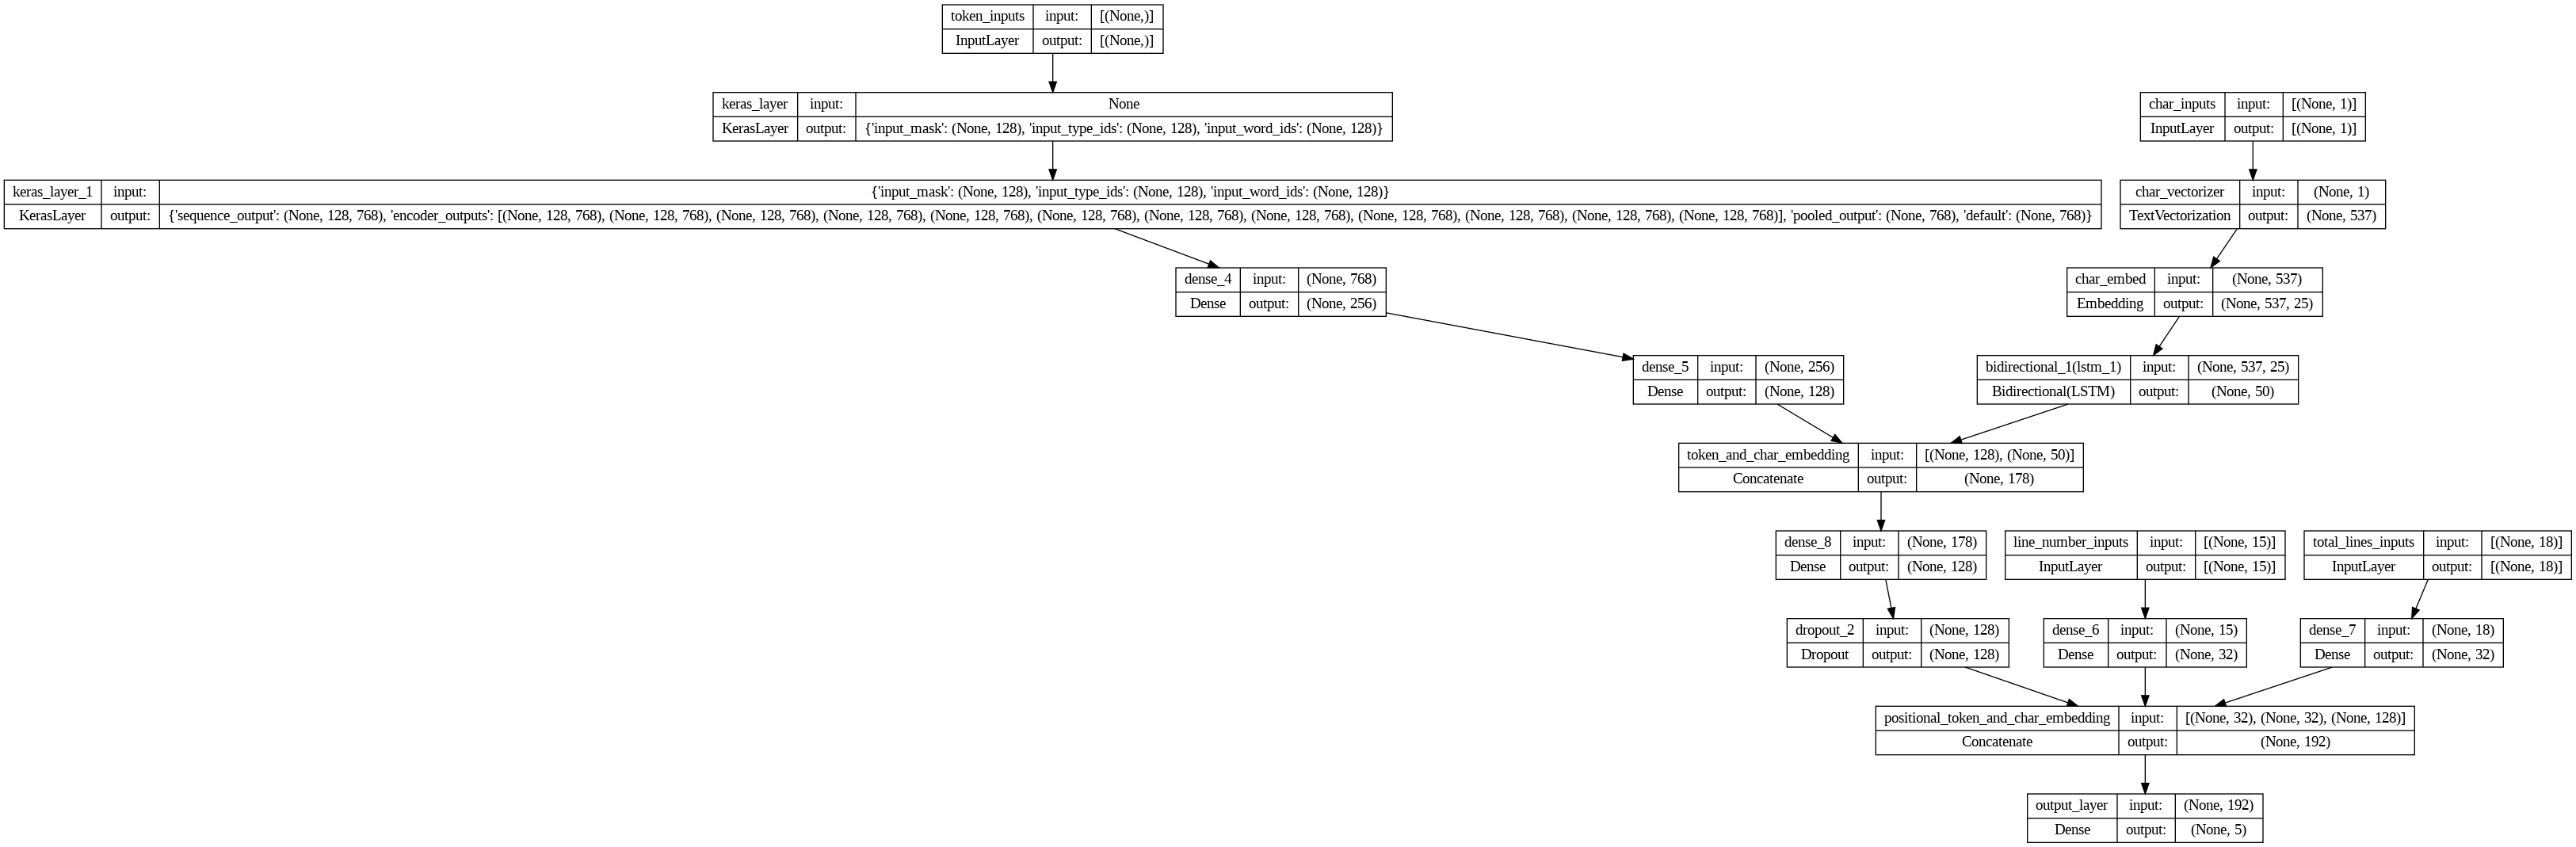

In [ ]:
# plot a model
keras.utils.plot_model(pos_token_char_model, show_shapes=True)

In [ ]:
# fit a model
history_two = pos_token_char_model.fit(train_pos_token_char_dataset,
                                       epochs=EPOCHS,
                                       steps_per_epoch=int(0.1 * len(train_pos_token_char_dataset)),
                                       validation_data=valid_pos_token_char_dataset,
                                       validation_steps=int(0.1 * len(valid_pos_token_char_dataset)),
                                       callbacks=[early_stopping])

Epoch 1/10
562/562 [==============================] - 264s 458ms/step - loss: 0.9507 - accuracy: 0.8203 - val_loss: 0.8824 - val_accuracy: 0.8594
Epoch 2/10
562/562 [==============================] - 248s 440ms/step - loss: 0.8823 - accuracy: 0.8628 - val_loss: 0.8660 - val_accuracy: 0.8634
Epoch 3/10
562/562 [==============================] - 247s 439ms/step - loss: 0.8713 - accuracy: 0.8689 - val_loss: 0.8583 - val_accuracy: 0.8650
Epoch 4/10
562/562 [==============================] - 247s 440ms/step - loss: 0.8705 - accuracy: 0.8707 - val_loss: 0.8562 - val_accuracy: 0.8760
Epoch 5/10
562/562 [==============================] - 255s 454ms/step - loss: 0.8647 - accuracy: 0.8756 - val_loss: 0.8644 - val_accuracy: 0.8677
Epoch 6/10
562/562 [==============================] - 247s 440ms/step - loss: 0.8689 - accuracy: 0.8706 - val_loss: 0.8509 - val_accuracy: 0.8876
Epoch 7/10
562/562 [==============================] - 255s 453ms/step - loss: 0.8602 - accuracy: 0.8780 - val_loss: 0.8466 -

#### Evaluate Pos + Token + Char model performance

In [ ]:
pos_token_char_results = pos_token_char_model.evaluate(valid_pos_token_char_dataset)
pos_token_char_results

945/945 [==============================] - 339s 358ms/step - loss: 0.8485 - accuracy: 0.8802


[0.848534882068634, 0.8801800608634949]

In [ ]:
# compare with the first results
token_char_results

[0.8850782513618469, 0.8587978482246399]

The second model got slightly improving from the first model with only `token + chars model` about **2%**

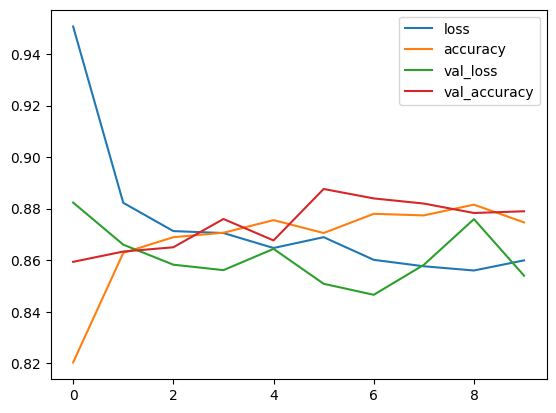

In [ ]:
# check model history learned
pd.DataFrame(history_two.history).plot();

From the second model, it looks like the model history learned it not much improvement from the first model....

In [ ]:
# make prediction
pos_token_char_probs = pos_token_char_model.predict(test_pos_token_char_dataset)
pos_token_char_preds = tf.argmax(pos_token_char_probs, axis=1)
pos_token_char_preds

942/942 [==============================] - 334s 354ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
test_labels

array([0, 4, 4, ..., 4, 4, 1])

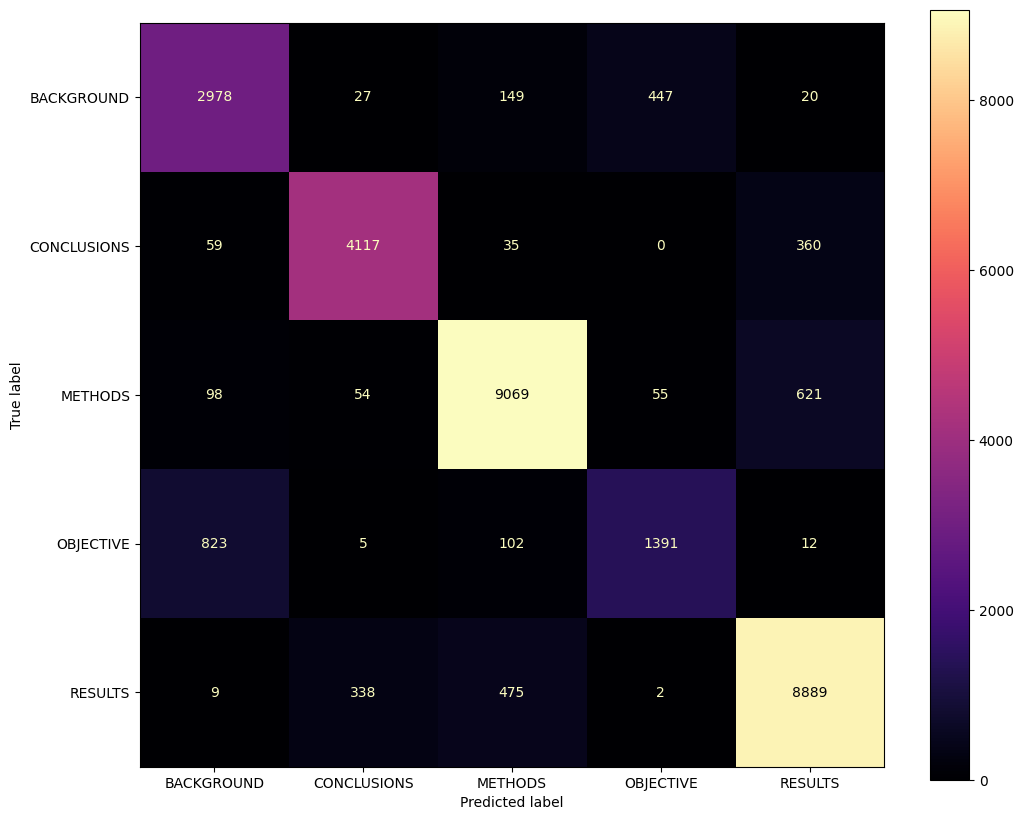

In [ ]:
# check confusion matrix
cm_display(test_labels, pos_token_char_preds)

Although the confusion matrix model predict has improvement of each labels but still strugle distinguish between `OBJECTIVE` and `BACKGROUND` label that has the most wrong predictions

## Save and Load a model

In [ ]:
# save model
pos_token_char_model.save("Skimlit_BERT_pos_token_char_model")

In [ ]:
# load model
loaded_model = keras.models.load_model("Skimlit_BERT_pos_token_char_model")
loaded_model.evaluate(test_pos_token_char_dataset)

942/942 [==============================] - 329s 347ms/step - loss: 0.8533 - accuracy: 0.8789


[0.8533332347869873, 0.878911554813385]

In [ ]:
pos_token_char_results

[0.848534882068634, 0.8801800608634949]

## Visualize model prediction

In [ ]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
# make prediction
model_probs = loaded_model.predict(test_pos_token_char_dataset)
model_preds = tf.argmax(model_probs, axis=1)
model_preds

942/942 [==============================] - 340s 362ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
label_preds = class_names[model_preds]
label_preds

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'RESULTS',
       'CONCLUSIONS'], dtype=object)

In [ ]:
# visualize ten prediction on test dataset
for _ in range(10):
  rdm_num = random.randint(0, len(test_df))
  row_df = test_df.iloc[rdm_num]
  true_label = class_names[test_labels[rdm_num]]
  pred_label = label_preds[rdm_num]
  correct = true_label == pred_label
  print(f"Label text: '{true_label}' | Model prediction: '{pred_label}'")
  print(f"Correct: {correct} >>> Probability: {tf.reduce_max(model_probs[rdm_num]) * 100: .2f}%")
  print(f"Text:\n{row_df['text']}\n")
  print("---------------------------------------------------------------------------------------\n")

Label text: 'CONCLUSIONS' | Model prediction: 'CONCLUSIONS'
Correct: True >>> Probability:  69.17%
Text:
this research suggests that hiv prevention programmes must carefully consider how the association many people make between hiv and death may interact with people 's perceptions of their vulnerability to hiv infection to affect their willingness to engage in preventative behaviours .

---------------------------------------------------------------------------------------

Label text: 'CONCLUSIONS' | Model prediction: 'CONCLUSIONS'
Correct: True >>> Probability:  85.45%
Text:
these results show that using polyhexanide is efficient for the prevention of exit-site infections .

---------------------------------------------------------------------------------------

Label text: 'BACKGROUND' | Model prediction: 'BACKGROUND'
Correct: True >>> Probability:  60.03%
Text:
severe acute pancreatitis is a life-threatening disease .

---------------------------------------------------------------

## Find the most wrong predictions

In [ ]:
test_df.head(10)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [ ]:
# check class names
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
correct = test_labels == model_preds
correct

<tf.Tensor: shape=(30135,), dtype=bool, numpy=array([False, False, False, ...,  True,  True,  True])>

In [ ]:
# make a copy of 'test_df'
test_df_preds = test_df

# take the 'target' column to slide into the last column
original_class = test_df_preds.pop('target')
test_df_preds['target'] = original_class
test_df_preds.head(10)

,text,line_number,total_lines,target
0,this study analyzed liver function abnormaliti...,0,8,BACKGROUND
1,a post hoc analysis was conducted with the use...,1,8,RESULTS
2,liver function tests ( lfts ) were measured at...,2,8,RESULTS
3,survival analyses were used to assess the asso...,3,8,RESULTS
4,the percentage of patients with abnormal lfts ...,4,8,RESULTS
5,when mean hemodynamic profiles were compared i...,5,8,RESULTS
6,multivariable analyses revealed that patients ...,6,8,RESULTS
7,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS
8,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS
9,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND


In [ ]:
# Add new columns to dataframe
test_df_preds['prediction'] = label_preds
test_df_preds['probability'] = tf.reduce_max(model_probs, axis=1)
test_df_preds['correct'] = correct

test_df_preds.head(7)

,text,line_number,total_lines,target,prediction,probability,correct
0,this study analyzed liver function abnormaliti...,0,8,BACKGROUND,OBJECTIVE,0.698574,False
1,a post hoc analysis was conducted with the use...,1,8,RESULTS,METHODS,0.693017,False
2,liver function tests ( lfts ) were measured at...,2,8,RESULTS,METHODS,0.730113,False
3,survival analyses were used to assess the asso...,3,8,RESULTS,RESULTS,0.742873,True
4,the percentage of patients with abnormal lfts ...,4,8,RESULTS,RESULTS,0.817886,True
5,when mean hemodynamic profiles were compared i...,5,8,RESULTS,RESULTS,0.866893,True
6,multivariable analyses revealed that patients ...,6,8,RESULTS,RESULTS,0.875494,True


In [ ]:
test_df_preds.tail(7)

,text,line_number,total_lines,target,prediction,probability,correct
30128,adverse effects were also monitored .,11,17,METHODS,METHODS,0.698623,True
30129,there was a statistically significant within-g...,12,17,RESULTS,RESULTS,0.820976,True
30130,there was a statistically significant between-...,13,17,RESULTS,RESULTS,0.812144,True
30131,there were no statistically significant betwee...,14,17,RESULTS,RESULTS,0.792694,True
30132,there was no significant association between s...,15,17,RESULTS,RESULTS,0.769948,True
30133,no adverse effects were reported .,16,17,RESULTS,RESULTS,0.732028,True
30134,performing a @-week do-as-tolerated program of...,17,17,CONCLUSIONS,CONCLUSIONS,0.816050,True


In [ ]:
test_df_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30135 entries, 0 to 30134
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text         30135 non-null  object 
 1   line_number  30135 non-null  int64  
 2   total_lines  30135 non-null  int64  
 3   target       30135 non-null  object 
 4   prediction   30135 non-null  object 
 5   probability  30135 non-null  float32
 6   correct      30135 non-null  bool   
dtypes: bool(1), float32(1), int64(2), object(3)
memory usage: 1.3+ MB


In [ ]:
# sorting only takes False predcition
most_wrong_df = test_df_preds[test_df_preds['target'] != test_df_preds['prediction']].sort_values('probability', ascending=False)
most_wrong_df.head(10)

,text,line_number,total_lines,target,prediction,probability,correct
16521,controlled trials.com/isrctn@ .,2,15,METHODS,BACKGROUND,0.938328,False
11133,to compare the safety and efficacy of dexmedet...,0,11,BACKGROUND,OBJECTIVE,0.894158,False
16634,to investigate whether remote ischemic conditi...,0,11,BACKGROUND,OBJECTIVE,0.891016,False
10452,to validate the association between accommodat...,0,10,BACKGROUND,OBJECTIVE,0.890688,False
13860,to evaluate efficacy and side effects of glyci...,0,9,BACKGROUND,OBJECTIVE,0.889484,False
14812,"at baseline , a high proportion of patients ha...",7,8,CONCLUSIONS,RESULTS,0.888313,False
835,to assess the temporal patterns of late gastro...,0,11,BACKGROUND,OBJECTIVE,0.886517,False
26058,to compare the efficacy of the newcastle infan...,0,9,BACKGROUND,OBJECTIVE,0.886092,False
16347,to evaluate the effects of the lactic acid bac...,0,12,BACKGROUND,OBJECTIVE,0.883571,False
6339,national institute of child-health and the kid...,2,20,METHODS,BACKGROUND,0.880533,False


In [ ]:
most_wrong_df.tail(10)

,text,line_number,total_lines,target,prediction,probability,correct
4088,"estimates of disease progression , death , and...",3,11,METHODS,BACKGROUND,0.282573,False
28859,"maintenance of motor function , tone , grip st...",1,8,OBJECTIVE,BACKGROUND,0.280649,False
7816,"at @ days , the pi approach was associated wit...",1,10,BACKGROUND,RESULTS,0.279391,False
28107,exogenous ifn - restores antiviral activity .,1,8,BACKGROUND,RESULTS,0.279281,False
1381,s. thermophilus st@ and tara gum create a gell...,2,11,BACKGROUND,RESULTS,0.276542,False
22448,the interviews explored women 's views towards...,4,9,METHODS,RESULTS,0.270985,False
20860,the primary objective is to assess the extent ...,5,8,METHODS,BACKGROUND,0.267116,False
15864,the study showed that the treatment led to imp...,3,11,BACKGROUND,RESULTS,0.265630,False
25121,"this trial was planned for @-@ weeks , with pr...",5,17,METHODS,BACKGROUND,0.245970,False
22010,aim of this prospective randomized trial is to...,7,15,BACKGROUND,METHODS,0.229861,False


In [ ]:
most_wrong_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3649 entries, 16521 to 22010
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text         3649 non-null   object 
 1   line_number  3649 non-null   int64  
 2   total_lines  3649 non-null   int64  
 3   target       3649 non-null   object 
 4   prediction   3649 non-null   object 
 5   probability  3649 non-null   float32
 6   correct      3649 non-null   bool   
dtypes: bool(1), float32(1), int64(2), object(3)
memory usage: 188.9+ KB


In [ ]:
# Visualize most top 10 most wrong predictions
for row in most_wrong_df[:10].itertuples():
  _, text, line_number, total_lines, target, prediction, prob, _ = row
  print(f"Label: `{target}` | Model prediction: `{prediction}`, with {prob * 100: .2f}% probability.")
  print(f"Text:\n{text}\n")
  print("-------------------------------------------------------------------------------------------\n")

Label: `METHODS` | Model prediction: `BACKGROUND`, with  93.83% probability.
Text:
controlled trials.com/isrctn@ .

-------------------------------------------------------------------------------------------

Label: `BACKGROUND` | Model prediction: `OBJECTIVE`, with  89.42% probability.
Text:
to compare the safety and efficacy of dexmedetomidine/propofol ( dp ) - total i.v. anaesthesia ( tiva ) vs remifentanil/propofol ( rp ) - tiva , both with spontaneous breathing , during airway foreign body ( fb ) removal in children .

-------------------------------------------------------------------------------------------

Label: `BACKGROUND` | Model prediction: `OBJECTIVE`, with  89.10% probability.
Text:
to investigate whether remote ischemic conditioning ( ric ) can attenuate ischemic reperfusion injury ( iri ) in recipients after kidney transplantation using donation after cardiac death .

-------------------------------------------------------------------------------------------

Label: `

By finding out the effect of wrong prediction we can occur for further development in the future, either from the get more data or the improvisation of the model itself

## Make prediction on real dataset

In [ ]:
import json

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-07-23 14:48:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-07-23 14:48:41 (72.4 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

There are 4 RCT abstracts we can try to predict with the model

In [ ]:
abstracts_df = pd.DataFrame(example_abstracts)
abstracts_df

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


### First row

In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object


# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines_zero = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines_zero = [sentence.lower() for sentence in abstract_lines_zero]
abstract_lines_zero

['this rct examined the efficacy of a manualized social intervention for children with hfasds.',
 'participants were randomly assigned to treatment or wait-list conditions.',
 'treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'a response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'high levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Create a function to preprocessing raw dataset
def template_sample(list_sentences: list):
  """
  Preprocessing template data for SkimLit model prediction.
  from list of sentences into:
  [{'line_number': 0,
  'text': 'to investigate the efficacy of 3 weeks of daily low-dose oral prednisolone in improving pain.
  'total_lines': 11},
  ...]
  """
  # raise error if not pass in list
  if not isinstance(list_sentences, list):
    raise TypeError("The Parameter must be a list.")

  # raise error if there is something else beside `str` in the list
  for item in list_sentences:
    if not isinstance(item, str):
      raise ValueError("All elements in the list must be strings.")

  total_abstract_lines = len(list_sentences)

  sample_dataset = []
  for i, sentence in enumerate(list_sentences):
    sample_dict = {}
    sample_dict['text'] = str(sentence)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_abstract_lines - 1
    sample_dataset.append(sample_dict)

  return sample_dataset

In [ ]:
sample_dataset_zero = template_sample(abstract_lines_zero)
sample_dataset_zero

[{'text': 'this rct examined the efficacy of a manualized social intervention for children with hfasds.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'a response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

Now we've got `"line_number"` and `"total_lines"` values, we can one-hot encode them with `tf.one_hot` just like we did with our training dataset (using the same values for the `depth` parameter).

In [ ]:
# 'line_number' encoding
sample_line_number_zero = [line['line_number'] for line in sample_dataset_zero]
sample_line_number_zero_encode = tf.one_hot(sample_line_number_zero, depth=15)

sample_line_number_zero_encode[:10], sample_line_number_zero

(<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 [0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
# 'total_lines' encoding
sample_total_lines_zero = [line['total_lines'] for line in sample_dataset_zero]
sample_total_lines_zero_encode = tf.one_hot(sample_total_lines_zero, depth=18)

sample_total_lines_zero_encode[:10], sample_total_lines_zero

(<tf.Tensor: shape=(8, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 [7, 7, 7, 7, 7, 7, 7, 7])

In [ ]:
# split each word from abstract lines
abstract_chars_zero = [split_chars(sentence) for sentence in abstract_lines_zero]
abstract_chars_zero[:3]

['t h i s   r c t   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   h f a s d s .',
 'p a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 't r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .']

In [ ]:
# Make predictions on sample abstract features
%%time
sample_abstract_zero_probs = loaded_model.predict(x=(sample_line_number_zero_encode,
                                                sample_total_lines_zero_encode,
                                                tf.constant(abstract_lines_zero),
                                                tf.constant(abstract_chars_zero)))
sample_abstract_zero_preds = tf.argmax(sample_abstract_zero_probs, axis=1)
sample_abstract_zero_preds

1/1 [==============================] - 2s 2s/step
CPU times: user 1.96 s, sys: 19.2 ms, total: 1.97 s
Wall time: 2.07 s


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 4])>

In [ ]:
sample_abstract_label_zero_preds = class_names[sample_abstract_zero_preds]
sample_abstract_label_zero_preds

array(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS',
       'RESULTS', 'RESULTS'], dtype=object)

In [ ]:
# visualize model prediction with its label prediction
for i, sentence in enumerate(abstract_lines_zero):
  print(f"Label prediction: '{sample_abstract_label_zero_preds[i]}' with probability {tf.reduce_max(sample_abstract_zero_probs[i]) * 100:.2f}%")
  print(f"Text:\n{sentence}\n")
  print("--------------------------------------------------------------------------------------------------------------------------\n")

Label prediction: 'OBJECTIVE' with probability 63.97%
Text:
this rct examined the efficacy of a manualized social intervention for children with hfasds.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'METHODS' with probability 82.56%
Text:
participants were randomly assigned to treatment or wait-list conditions.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'METHODS' with probability 79.58%
Text:
treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'METHODS' with probability 79.09%
Text:
a response-cost program was applied to reduce probl

Now, let's make predictions in all the rest of the abstract lines in dataset

### Second row

In [ ]:
# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[1]["abstract"])
abstract_lines_one = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines_one = [sentence.lower() for sentence in abstract_lines_one]
abstract_lines_one

['postpartum depression (ppd) is the most prevalent mood disorder associated with childbirth.',
 'no single cause of ppd has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
 'three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for ppd; omega-3 (n-3) long chain polyunsaturated fatty acids (lcpufa), vitamin d and overall diet.',
 "we searched for meta-analyses of randomised controlled trials (rct's) of nutritional interventions during the perinatal period with ppd as an outcome, and checked for any trials published subsequently to the meta-analyses.",
 "fish oil: eleven rct's of prenatal fish oil supplementation rct's show null and positive effects on ppd symptoms.",
 "vitamin d: no relevant rct's were identified, however seven observational studies o

In [ ]:
sample_dataset_one = template_sample(abstract_lines_one)
sample_dataset_one

[{'text': 'postpartum depression (ppd) is the most prevalent mood disorder associated with childbirth.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'no single cause of ppd has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for ppd; omega-3 (n-3) long chain polyunsaturated fatty acids (lcpufa), vitamin d and overall diet.',
  'line_number': 2,
  'total_lines': 9},
 {'text': "we searched for meta-analyses of randomised controlled trials (rct's) of nutritional interventions during the perinatal period with ppd as an outcome, and checked for any trials published subsequently to the meta-analyses.",
  'line_number': 3,
  'total_lines': 9},
 {'

In [ ]:
# encode line number values
sample_line_number_one = [line["line_number"] for line in sample_dataset_one]
sample_line_number_one_encode = tf.one_hot(sample_line_number_one, depth=15)

sample_line_number_one_encode[:10], sample_line_number_one

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# encode line number values
sample_total_lines_one = [line["total_lines"] for line in sample_dataset_one]
sample_total_lines_one_encode = tf.one_hot(sample_total_lines_one, depth=18)

sample_total_lines_one_encode[:10], sample_total_lines_one

(<tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 [9, 9, 9, 9, 9, 9, 9

In [ ]:
# split each word in abstract lines
abstract_chars_one = [split_chars(sentence) for sentence in abstract_lines_one]
abstract_chars_one[:3]

['p o s t p a r t u m   d e p r e s s i o n   ( p p d )   i s   t h e   m o s t   p r e v a l e n t   m o o d   d i s o r d e r   a s s o c i a t e d   w i t h   c h i l d b i r t h .',
 'n o   s i n g l e   c a u s e   o f   p p d   h a s   b e e n   i d e n t i f i e d ,   h o w e v e r   t h e   i n c r e a s e d   r i s k   o f   n u t r i t i o n a l   d e f i c i e n c i e s   i n c u r r e d   t h r o u g h   t h e   h i g h   n u t r i t i o n a l   r e q u i r e m e n t s   o f   p r e g n a n c y   m a y   p l a y   a   r o l e   i n   t h e   p a t h o l o g y   o f   d e p r e s s i v e   s y m p t o m s .',
 't h r e e   n u t r i t i o n a l   i n t e r v e n t i o n s   h a v e   d r a w n   p a r t i c u l a r   i n t e r e s t   a s   p o s s i b l e   n o n - i n v a s i v e   a n d   c o s t - e f f e c t i v e   p r e v e n t i o n   a n d / o r   t r e a t m e n t   s t r a t e g i e s   f o r   p p d ;   o m e g a - 3   ( n - 3 )   l o n g   c h a i n   p o l y u 

In [ ]:
# Make predictions on sample abstract features
%%time
sample_abstract_one_probs = loaded_model.predict(x=(sample_line_number_one_encode,
                                                sample_total_lines_one_encode,
                                                tf.constant(abstract_lines_one),
                                                tf.constant(abstract_chars_one)))
sample_abstract_one_preds = tf.argmax(sample_abstract_one_probs, axis=1)
sample_abstract_one_preds

1/1 [==============================] - 0s 54ms/step
CPU times: user 225 ms, sys: 6.73 ms, total: 232 ms
Wall time: 220 ms


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 0, 4, 1, 1, 1, 1])>

In [ ]:
sample_abstract_label_one_preds = class_names[sample_abstract_one_preds]
sample_abstract_label_one_preds

array(['BACKGROUND', 'BACKGROUND', 'BACKGROUND', 'METHODS', 'BACKGROUND',
       'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [ ]:
# visualize model prediction with its label prediction
for i, sentence in enumerate(abstract_lines_one):
  print(f"Label prediction: '{sample_abstract_label_one_preds[i]}' with probability {tf.reduce_max(sample_abstract_one_probs[i]) * 100:.2f}%")
  print(f"Text:\n{sentence}\n")
  print("--------------------------------------------------------------------------------------------------------------------------\n")

Label prediction: 'BACKGROUND' with probability 52.47%
Text:
postpartum depression (ppd) is the most prevalent mood disorder associated with childbirth.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 55.69%
Text:
no single cause of ppd has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 59.66%
Text:
three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for ppd; omega-3 (n-3) long chain polyunsaturated fatty acids (lcpufa), vitamin d and overall diet.

--------

### Third row

In [ ]:
# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[2]["abstract"])
abstract_lines_sec = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines_sec = [sentence.lower() for sentence in abstract_lines_sec]
abstract_lines_sec

['mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.',
 'treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.',
 'there are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.',
 'this review provides an overview of the nutritional psychiatry field.',
 'it includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research.',
 'potential biological pathways related to mental disorders include inflammation

In [ ]:
sample_dataset_sec = template_sample(abstract_lines_sec)
sample_dataset_sec

[{'text': 'mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'there are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.',
  'line_number': 2,
  'total_lines': 9},
 {'text': 'this review provides an overview of the nutritional psychiatry field.',
  'line_number': 3,
  'total_lines': 9},
 {'text': 'it includes a discussion of the neurobiological mechanisms likely modula

In [ ]:
# encode `line_number` values
sample_line_number_sec = [line['line_number'] for line in sample_dataset_sec]
sample_line_number_sec_encode = tf.one_hot(sample_line_number_sec, depth=15)
sample_line_number_sec_encode[:7], sample_line_number_sec

(<tf.Tensor: shape=(7, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# encode `total_lines` values
sample_total_lines_sec = [line['total_lines'] for line in sample_dataset_sec]
sample_total_lines_sec_encode = tf.one_hot(sample_total_lines_sec, depth=18)
sample_total_lines_sec_encode[:7], sample_total_lines_sec

(<tf.Tensor: shape=(7, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
abstract_chars_sec = [split_chars(sentence) for sentence in abstract_lines_sec]
abstract_chars_sec[:3]

['m e n t a l   i l l n e s s ,   i n c l u d i n g   d e p r e s s i o n ,   a n x i e t y   a n d   b i p o l a r   d i s o r d e r ,   a c c o u n t s   f o r   a   s i g n i f i c a n t   p r o p o r t i o n   o f   g l o b a l   d i s a b i l i t y   a n d   p o s e s   a   s u b s t a n t i a l   s o c i a l ,   e c o n o m i c   a n d   h e a t h   b u r d e n .',
 't r e a t m e n t   i s   p r e s e n t l y   d o m i n a t e d   b y   p h a r m a c o t h e r a p y ,   s u c h   a s   a n t i d e p r e s s a n t s ,   a n d   p s y c h o t h e r a p y ,   s u c h   a s   c o g n i t i v e   b e h a v i o u r a l   t h e r a p y ;   h o w e v e r ,   s u c h   t r e a t m e n t s   a v e r t   l e s s   t h a n   h a l f   o f   t h e   d i s e a s e   b u r d e n ,   s u g g e s t i n g   t h a t   a d d i t i o n a l   s t r a t e g i e s   a r e   n e e d e d   t o   p r e v e n t   a n d   t r e a t   m e n t a l   d i s o r d e r s .',
 't h e r e   a r e   n o w   c o n s 

In [ ]:
# Make predictions on sample abstract features
%%time
sample_abstract_sec_probs = loaded_model.predict(x=(sample_line_number_sec_encode,
                                                sample_total_lines_sec_encode,
                                                tf.constant(abstract_lines_sec),
                                                tf.constant(abstract_chars_sec)))
sample_abstract_sec_preds = tf.argmax(sample_abstract_sec_probs, axis=1)
sample_abstract_sec_preds

1/1 [==============================] - 0s 51ms/step
CPU times: user 229 ms, sys: 4.06 ms, total: 233 ms
Wall time: 371 ms


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1])>

In [ ]:
sample_abstract_label_sec_preds = class_names[sample_abstract_sec_preds]
sample_abstract_label_sec_preds

array(['BACKGROUND', 'BACKGROUND', 'BACKGROUND', 'CONCLUSIONS',
       'CONCLUSIONS', 'BACKGROUND', 'CONCLUSIONS', 'CONCLUSIONS',
       'CONCLUSIONS', 'CONCLUSIONS'], dtype=object)

In [ ]:
# visualize model prediction with its label prediction
for i, sentence in enumerate(abstract_lines_sec):
  print(f"Label prediction: '{sample_abstract_label_sec_preds[i]}' with probability {tf.reduce_max(sample_abstract_sec_probs[i]) * 100:.2f}%")
  print(f"Text:\n{sentence}\n")
  print("--------------------------------------------------------------------------------------------------------------------------\n")

Label prediction: 'BACKGROUND' with probability 53.59%
Text:
mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 56.78%
Text:
treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 53.01%
Text:
there are now consistent mechanistic, observational and interventional data to suggest d

### Fourth row

In [ ]:
doc = nlp(example_abstracts[3]['abstract'])
abstract_lines_third = [str(sen) for sen in list(doc.sents)]
abstract_lines_third = [sentence.lower() for sentence in abstract_lines_third]
abstract_lines_third

['hepatitis c virus (hcv) and alcoholic liver disease (ald), either alone or in combination, count for more than two thirds of all liver diseases in the western world.',
 'there is no safe level of drinking in hcv-infected patients and the most effective goal for these patients is total abstinence.',
 'baclofen, a gaba(b) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (ad).',
 'previously, we performed a randomized clinical trial (rct), which demonstrated the safety and efficacy of baclofen in patients affected by ad and cirrhosis.',
 "the goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent hcv-infected cirrhotic patients.",
 'any patient with hcv infection was selected for this analysis.',
 'among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a hcv infection; 12 received baclofen 10mg t.i.d.',
 'and 12 received placebo for 12-weeks.',
 'with respect to the placeb

In [ ]:
sample_dataset_third = template_sample(abstract_lines_third)
sample_dataset_third

[{'text': 'hepatitis c virus (hcv) and alcoholic liver disease (ald), either alone or in combination, count for more than two thirds of all liver diseases in the western world.',
  'line_number': 0,
  'total_lines': 11},
 {'text': 'there is no safe level of drinking in hcv-infected patients and the most effective goal for these patients is total abstinence.',
  'line_number': 1,
  'total_lines': 11},
 {'text': 'baclofen, a gaba(b) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (ad).',
  'line_number': 2,
  'total_lines': 11},
 {'text': 'previously, we performed a randomized clinical trial (rct), which demonstrated the safety and efficacy of baclofen in patients affected by ad and cirrhosis.',
  'line_number': 3,
  'total_lines': 11},
 {'text': "the goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent hcv-infected cirrhotic patients.",
  'line_number': 4,
  'total_lines': 11},
 {'text': 'any patient with hcv 

In [ ]:
# encode `line_number` values
sample_line_number_third = [line['line_number'] for line in sample_dataset_third]
sample_line_number_third_encode = tf.one_hot(sample_line_number_third, depth=15)
sample_line_number_third_encode[:7], sample_line_number_third

(<tf.Tensor: shape=(7, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [ ]:
# encode `total_lines` values
sample_total_lines_third = [line['total_lines'] for line in sample_dataset_third]
sample_total_lines_third_encode = tf.one_hot(sample_total_lines_third, depth=18)
sample_total_lines_third_encode[:7], sample_total_lines_third

(<tf.Tensor: shape=(7, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [ ]:
abstract_chars_third = [split_chars(sentence) for sentence in abstract_lines_third]
abstract_chars_third[:3]

['h e p a t i t i s   c   v i r u s   ( h c v )   a n d   a l c o h o l i c   l i v e r   d i s e a s e   ( a l d ) ,   e i t h e r   a l o n e   o r   i n   c o m b i n a t i o n ,   c o u n t   f o r   m o r e   t h a n   t w o   t h i r d s   o f   a l l   l i v e r   d i s e a s e s   i n   t h e   w e s t e r n   w o r l d .',
 't h e r e   i s   n o   s a f e   l e v e l   o f   d r i n k i n g   i n   h c v - i n f e c t e d   p a t i e n t s   a n d   t h e   m o s t   e f f e c t i v e   g o a l   f o r   t h e s e   p a t i e n t s   i s   t o t a l   a b s t i n e n c e .',
 'b a c l o f e n ,   a   g a b a ( b )   r e c e p t o r   a g o n i s t ,   r e p r e s e n t s   a   p r o m i s i n g   p h a r m a c o t h e r a p y   f o r   a l c o h o l   d e p e n d e n c e   ( a d ) .']

In [ ]:
# Make predictions on sample abstract features
%%time
sample_abstract_third_probs = loaded_model.predict(x=(sample_line_number_third_encode,
                                                sample_total_lines_third_encode,
                                                tf.constant(abstract_lines_third),
                                                tf.constant(abstract_chars_third)))
sample_abstract_third_preds = tf.argmax(sample_abstract_third_probs, axis=1)
sample_abstract_third_preds

1/1 [==============================] - 0s 57ms/step
CPU times: user 255 ms, sys: 6.91 ms, total: 262 ms
Wall time: 369 ms


<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 0, 0, 0, 3, 2, 4, 2, 4, 4, 1, 1])>

In [ ]:
sample_abstract_label_third_preds = class_names[sample_abstract_third_preds]
sample_abstract_label_third_preds

array(['BACKGROUND', 'BACKGROUND', 'BACKGROUND', 'BACKGROUND',
       'OBJECTIVE', 'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'RESULTS',
       'CONCLUSIONS', 'CONCLUSIONS'], dtype=object)

In [ ]:
# visualize model prediction with its label prediction
for i, sentence in enumerate(abstract_lines_third):
  print(f"Label prediction: '{sample_abstract_label_third_preds[i]}' with probability {tf.reduce_max(sample_abstract_third_probs[i]) * 100:.2f}%")
  print(f"Text:\n{sentence}\n")
  print("--------------------------------------------------------------------------------------------------------------------------\n")

Label prediction: 'BACKGROUND' with probability 66.62%
Text:
hepatitis c virus (hcv) and alcoholic liver disease (ald), either alone or in combination, count for more than two thirds of all liver diseases in the western world.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 62.57%
Text:
there is no safe level of drinking in hcv-infected patients and the most effective goal for these patients is total abstinence.

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probability 63.63%
Text:
baclofen, a gaba(b) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (ad).

--------------------------------------------------------------------------------------------------------------------------

Label prediction: 'BACKGROUND' with probab